# 0. Configurações iniciais

In [96]:
import pandas as pd
import numpy as np

In [97]:
transactions_retail = pd.read_excel('/content/OnlineRetail.xlsx')
transactions_retail['CustomerID'] = transactions_retail['CustomerID'].astype('object') # transformando em caractere

#1. Obtendo e organizando os dados

In [98]:
# Ajustando os dados base
transactions_retail['Value'] = transactions_retail['Quantity'] * transactions_retail['UnitPrice']
transactions_retail = transactions_retail.dropna()
transactions_retail = transactions_retail[transactions_retail['Value'] > 0]
transactions_retail = transactions_retail[np.isin(transactions_retail['StockCode'],['POST','M','D','CRUK','C2'],invert=True)]
transactions_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom,20.34


In [99]:
# Obtendo a base agregando os pedidos
invoices_retail = transactions_retail.groupby(['InvoiceNo','InvoiceDate','CustomerID','Country'],as_index=True).agg({'Value': 'sum', 'InvoiceNo': 'size'})
invoices_retail.columns = ['TotalValue','NTransactions']
invoices_retail = invoices_retail.reset_index()
invoices_retail.head()

,InvoiceNo,InvoiceDate,CustomerID,Country,TotalValue,NTransactions
0,536365,2016-11-29,17850.0,United Kingdom,139.12,7
1,536366,2016-11-29,17850.0,United Kingdom,22.20,2
2,536367,2016-11-29,13047.0,United Kingdom,278.73,12
3,536368,2016-11-29,13047.0,United Kingdom,70.05,4
4,536369,2016-11-29,13047.0,United Kingdom,17.85,1


In [100]:
# Obtendo a base a respeito dos clientes
customers_retail = invoices_retail.groupby('CustomerID').agg({'InvoiceNo': pd.Series.nunique, 'TotalValue': 'sum', 'NTransactions': 'sum',
                                                              'Country': pd.Series.nunique, 'InvoiceDate':'max'})
customers_retail = customers_retail.reset_index()
customers_retail = customers_retail.assign(MultipleLocations = np.where(customers_retail['Country'] > 1,1,0),
                                           AvgValueInvoice = customers_retail['TotalValue']/customers_retail['InvoiceNo'],
                                           AvgValueTransaction = customers_retail['TotalValue']/customers_retail['NTransactions'],
                                           DaysLastInvoice = pd.to_datetime('2017-12-07') - customers_retail['InvoiceDate'])

#ajustando o formato das variáveis
customers_retail = customers_retail.astype({'CustomerID': 'object','DaysLastInvoice':'timedelta64[D]'})
customers_retail['DaysLastInvoice'] = customers_retail['DaysLastInvoice'].astype(int)
customers_retail.columns = ['CustomerID','NInvoices','TotalValue','Ntransactions','NCountries','RecentDate','MultipleLocations','AvgValueInvoice',
                            'AvgValueTransaction','DaysLastInvoice']

customers_retail.head()

,CustomerID,NInvoices,TotalValue,Ntransactions,NCountries,RecentDate,MultipleLocations,AvgValueInvoice,AvgValueTransaction,DaysLastInvoice
0,12346.0,1,77183.60,1,1,2017-01-16,0,77183.600000,77183.600000,325
1,12347.0,7,4310.00,182,1,2017-12-05,0,615.714286,23.681319,2
2,12348.0,4,1437.24,27,1,2017-09-23,0,359.310000,53.231111,75
3,12349.0,1,1457.55,72,1,2017-11-19,0,1457.550000,20.243750,18
4,12350.0,1,294.40,16,1,2017-01-31,0,294.400000,18.400000,310


In [101]:
# obtendo informações a respeito dos produtos
products_retail = transactions_retail.groupby('StockCode').agg({'InvoiceNo': pd.Series.nunique, 'Value': 'sum', 'Country': pd.Series.nunique,
                                                                'InvoiceDate': 'max'})
products_retail.reset_index()

products_retail = products_retail.assign(DaysLastInvoice = pd.to_datetime('2017-12-07') - products_retail['InvoiceDate'],
                                         AvgValue = products_retail['Value']/products_retail['InvoiceNo'],
                                         propValue = products_retail['Value']/ products_retail['Value'].sum(),
                                         propInvoices = products_retail['InvoiceNo']/products_retail['InvoiceNo'].sum())
products_retail = products_retail.reset_index()

#ajustando o formato das variáveis
products_retail = products_retail.astype({'StockCode': 'object','DaysLastInvoice':'timedelta64[D]'})
products_retail['DaysLastInvoice'] = products_retail['DaysLastInvoice'].astype(int)
products_retail.columns = ['StockCode','NInvoices','TotalValue','NCountries','RecentDate','DaysLastInvoice','AvgValue','propValue','propInvoices']

products_retail.head()

,StockCode,NInvoices,TotalValue,NCountries,RecentDate,DaysLastInvoice,AvgValue,propValue,propInvoices
0,10002,49,699.55,7,2017-04-16,235,14.276531,0.000080,0.000127
1,10080,21,114.41,1,2017-11-19,18,5.448095,0.000013,0.000054
2,10120,29,40.53,2,2017-12-02,5,1.397586,0.000005,0.000075
3,10125,61,930.30,4,2017-12-07,0,15.250820,0.000106,0.000158
4,10133,122,1143.61,6,2017-09-05,93,9.373852,0.000130,0.000316


In [102]:
customers_retail.head()

,CustomerID,NInvoices,TotalValue,Ntransactions,NCountries,RecentDate,MultipleLocations,AvgValueInvoice,AvgValueTransaction,DaysLastInvoice
0,12346.0,1,77183.60,1,1,2017-01-16,0,77183.600000,77183.600000,325
1,12347.0,7,4310.00,182,1,2017-12-05,0,615.714286,23.681319,2
2,12348.0,4,1437.24,27,1,2017-09-23,0,359.310000,53.231111,75
3,12349.0,1,1457.55,72,1,2017-11-19,0,1457.550000,20.243750,18
4,12350.0,1,294.40,16,1,2017-01-31,0,294.400000,18.400000,310


# 2. Segmentando os Clientes


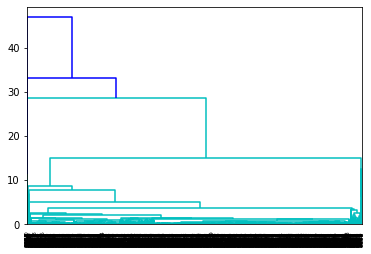

[1 6 6 ... 6 6 6]


In [117]:
# cluster hierarquico
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
%matplotlib inline

df = customers_retail
df = df.drop(['CustomerID','NCountries','RecentDate','MultipleLocations','AvgValueTransaction'], axis = 1)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

mergings = linkage(df_scaled, method = 'average')
dendrogram(mergings, leaf_rotation = 90, leaf_font_size = 6)
plt.show()

labels = fcluster(mergings, 15, criterion = 'distance')
print(labels)

[2 1 1 ... 1 1 1]


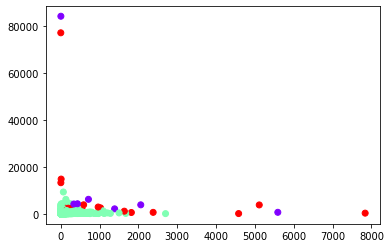

In [114]:
# cluster hierarquico - scikit learn
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(df)
print(cluster.labels_)
plt.scatter(df['Ntransactions'],df['AvgValueInvoice'], c=cluster.labels_, cmap='rainbow')

In [121]:
# k-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_scaled)

labels = kmeans.predict(df_scaled)
print(labels)

# avaliando
print(kmeans.inertia_)

[1 0 0 ... 0 0 0]
12019.783198006942


In [123]:
# RFM, utilizando quantis
# obtendo a qual quantil pertence tal registro
inv_labels = range(4,0,-1)
inv_quartiles = pd.qcut(df['DaysLastInvoice'],4, labels = inv_labels) #obtendo o quartil para os valores de DaysLastInvoice

val_labels = range(1,5)
val_quartiles = pd.qcut(df['AvgValueInvoice'],4,labels = val_labels) # obtendo os quarties para avg value

df = df.assign(I = inv_quartiles, V = val_quartiles)
df.head()

,NInvoices,TotalValue,Ntransactions,AvgValueInvoice,DaysLastInvoice,I,V
0,1,77183.60,1,77183.600000,325,1,4
1,7,4310.00,182,615.714286,2,4,4
2,4,1437.24,27,359.310000,75,2,3
3,1,1457.55,72,1457.550000,18,3,4
4,1,294.40,16,294.400000,310,1,3


# 3. Market Basket Analysis

Site para consulta: https://pbpython.com/market-basket-analysis.html

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
# transformar os dados tabulares em transações
basket = (transactions_retail.groupby(['InvoiceNo','StockCode'])['Quantity']
                             .sum().unstack().reset_index().fillna(0)
                             .set_index('InvoiceNo'))

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [ ]:
# utilizando o algoritmo apriori
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

In [ ]:
# obtendo as regras
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(20712),(22386),0.026720,0.047304,0.010808,0.404472,8.550556,0.009544,1.599750
1,(22386),(20712),0.047304,0.026720,0.010808,0.228473,8.550556,0.009544,1.261498
2,(20712),(85099B),0.026720,0.086895,0.014229,0.532520,6.128310,0.011907,1.953250
3,(85099B),(20712),0.086895,0.026720,0.014229,0.163750,6.128310,0.011907,1.163862
4,(20713),(85099B),0.022321,0.086895,0.010971,0.491484,5.656061,0.009031,1.795627


In [ ]:
# filtrando as regras conforme as preferências
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153,(21086),(21094),0.015478,0.017651,0.012817,0.828070,46.914634,0.012544,5.713665
437,(22579),(22578),0.014989,0.023516,0.012274,0.818841,34.820581,0.011921,5.390192
461,(22698),(22697),0.030196,0.037528,0.024982,0.827338,22.045987,0.023849,5.574318
505,(22746),(22745),0.013686,0.017162,0.011133,0.813492,47.401359,0.010899,5.269686
506,(22745),(22748),0.017162,0.018791,0.013795,0.803797,42.775499,0.013472,5.001000
508,(22746),(22748),0.013686,0.018791,0.011677,0.853175,45.403191,0.011419,6.682828
531,(23171),(23170),0.014664,0.017814,0.012437,0.848148,47.612658,0.012176,6.468057
533,(23172),(23170),0.012165,0.017814,0.010699,0.879464,49.370658,0.010482,8.148510
535,(23172),(23171),0.012165,0.014664,0.010971,0.901786,61.498446,0.010792,10.032517
1040,"(22698, 22423)",(22697),0.016782,0.037528,0.014718,0.877023,23.369925,0.014088,7.826418
